Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
team
[*********************100%***********************]  1 of 1 completed


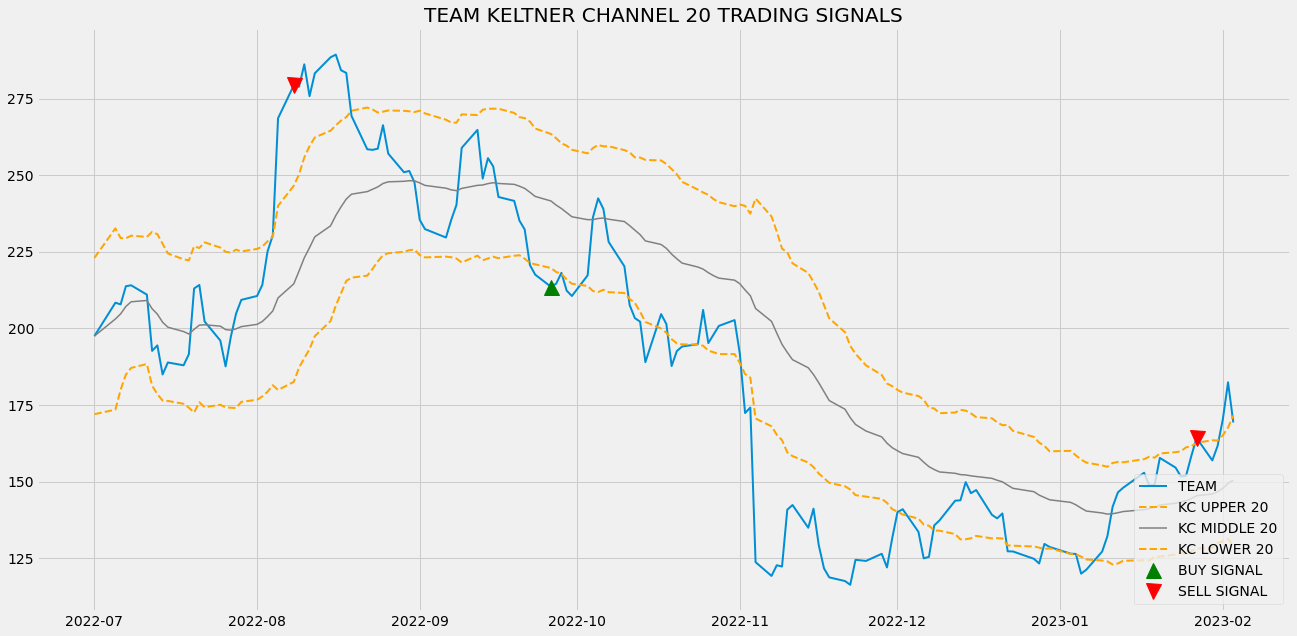

In [30]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from termcolor import colored as cl
from math import floor

plt.rcParams['figure.figsize'] = (20,10)
plt.style.use('fivethirtyeight')

!pip install yahoo_fin
!pip install yfinance
!pip install --upgrade pandas-datareader

import yfinance as yf
import pandas as pd
import pandas_datareader.data as pddata

ticker=input().upper()
name = str(ticker)

from datetime import datetime, date, timedelta
begin = '2022-07-01'
yesterday = (date.today() - timedelta(days=1)).strftime('%Y-%m-%d')
stock_data = yf.download(ticker, start=begin, end=yesterday)
stock_data.tail()

def get_kc(high, low, close, kc_lookback, multiplier, atr_lookback):
  tr1 = pd.DataFrame(high - low)
  tr2 = pd.DataFrame(abs(high - close.shift()))
  tr3 = pd.DataFrame(abs(low - close.shift()))
  frames = [tr1, tr2, tr3]
  tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
  atr = tr.ewm(alpha = 1/atr_lookback).mean()
  
  kc_middle = close.ewm(kc_lookback).mean()
  kc_upper = close.ewm(kc_lookback).mean() + multiplier * atr
  kc_lower = close.ewm(kc_lookback).mean() - multiplier * atr
    
  return kc_middle, kc_upper, kc_lower
    
stock_data = stock_data.iloc[:,:4]
stock_data['kc_middle'], stock_data['kc_upper'], stock_data['kc_lower'] = get_kc(stock_data['High'], stock_data['Low'], stock_data['Close'], 20, 2, 10)
# stock_data.tail()

def implement_kc_strategy(prices, kc_upper, kc_lower):
    buy_price = []
    sell_price = []
    kc_signal = []
    signal = 0
    
    for i in range(len(prices)):
        if prices[i] < kc_lower[i] and prices[i+1] > prices[i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                kc_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                kc_signal.append(0)
        elif prices[i] > kc_upper[i] and prices[i+1] < prices[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                kc_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                kc_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            kc_signal.append(0)
            
    return buy_price, sell_price, kc_signal

buy_price, sell_price, kc_signal = implement_kc_strategy(stock_data['Close'], stock_data['kc_upper'], stock_data['kc_lower'])

plt.plot(stock_data['Close'], linewidth = 2, label = name)
plt.plot(stock_data['kc_upper'], linewidth = 2, color = 'orange', linestyle = '--', label = 'KC UPPER 20')
plt.plot(stock_data['kc_middle'], linewidth = 1.5, color = 'grey', label = 'KC MIDDLE 20')
plt.plot(stock_data['kc_lower'], linewidth = 2, color = 'orange', linestyle = '--', label = 'KC LOWER 20')
plt.plot(stock_data.index, buy_price, marker = '^', color = 'green', markersize = 15, linewidth = 0, label = 'BUY SIGNAL')
plt.plot(stock_data.index, sell_price, marker = 'v', color= 'r', markersize = 15, linewidth = 0, label = 'SELL SIGNAL')
plt.legend(loc = 'lower right')
plt.title(name +' KELTNER CHANNEL 20 TRADING SIGNALS')
plt.show()


In [31]:
position = []
for i in range(len(kc_signal)):
    if kc_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(stock_data['Close'])):
    if kc_signal[i] == 1:
        position[i] = 1
    elif kc_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
close_price = stock_data['Close']
kc_upper = stock_data['kc_upper']
kc_lower = stock_data['kc_lower']
kc_signal = pd.DataFrame(kc_signal).rename(columns = {0:'kc_signal'}).set_index(stock_data.index)
position = pd.DataFrame(position).rename(columns = {0:'kc_position'}).set_index(stock_data.index)

frames = [close_price, kc_upper, kc_lower, kc_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy

,Close,kc_upper,kc_lower,kc_signal,kc_position
Date,,,,,
2022-07-01 00:00:00-04:00,197.509995,223.009995,172.009995,0,1
2022-07-05 00:00:00-04:00,208.389999,232.656359,173.509001,0,1
2022-07-06 00:00:00-04:00,207.850006,229.495670,180.004171,0,1
2022-07-07 00:00:00-04:00,213.770004,229.407768,184.937350,0,1
2022-07-08 00:00:00-04:00,214.080002,230.266643,187.117419,0,1
...,...,...,...,...,...
2023-01-30 00:00:00-05:00,156.940002,163.490440,128.422907,0,0
2023-01-31 00:00:00-05:00,161.619995,163.433509,129.972729,0,0
2023-02-01 00:00:00-05:00,170.309998,165.117430,130.538727,0,0


In [32]:
stock_data_ret = pd.DataFrame(np.diff(stock_data['Close'])).rename(columns = {0:'returns'})
kc_strategy_ret = []

for i in range(len(stock_data_ret)):
    returns = stock_data_ret['returns'][i]*strategy['kc_position'][i]
    kc_strategy_ret.append(returns)
    
kc_strategy_ret_df = pd.DataFrame(kc_strategy_ret).rename(columns = {0:'kc_returns'})
investment_value = 100000
number_of_stocks = floor(investment_value/stock_data['Close'][0])
kc_investment_ret = []

for i in range(len(kc_strategy_ret_df['kc_returns'])):
    returns = number_of_stocks*kc_strategy_ret_df['kc_returns'][i]
    kc_investment_ret.append(returns)

kc_investment_ret_df = pd.DataFrame(kc_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(kc_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the KC strategy by investing $100k in ' + name + ': {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the KC strategy : {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the KC strategy by investing $100k in TEAM: 16434.89
Profit percentage of the KC strategy : 16%


In [33]:
# SPY ETF COMPARISON

def get_benchmark(start_date, investment_value):
    spy = yf.download('SPY', start=begin, end=yesterday)['Close']
    benchmark = pd.DataFrame(np.diff(spy)).rename(columns = {0:'benchmark_returns'})
    
    investment_value = investment_value
    number_of_stocks = floor(investment_value/spy[-1])
    benchmark_investment_ret = []
    
    for i in range(len(benchmark['benchmark_returns'])):
        returns = number_of_stocks*benchmark['benchmark_returns'][i]
        benchmark_investment_ret.append(returns)

    benchmark_investment_ret_df = pd.DataFrame(benchmark_investment_ret).rename(columns = {0:'investment_returns'})
    return benchmark_investment_ret_df

benchmark = get_benchmark('2020-01-01', 100000)
investment_value = 100000
total_benchmark_investment_ret = round(sum(benchmark['investment_returns']), 2)
benchmark_profit_percentage = floor((total_benchmark_investment_ret/investment_value)*100)
print(cl('Benchmark profit by investing $100k : {}'.format(total_benchmark_investment_ret), attrs = ['bold']))
print(cl('Benchmark Profit percentage : {}%'.format(benchmark_profit_percentage), attrs = ['bold']))
print(cl('KC Strategy profit is {}% higher than the Benchmark Profit'.format(profit_percentage - benchmark_profit_percentage), attrs = ['bold']))

[*********************100%***********************]  1 of 1 completed
Benchmark profit by investing $100k : 7528.62
Benchmark Profit percentage : 7%
KC Strategy profit is 9% higher than the Benchmark Profit


In [5]:
from datetime import datetime, date, timedelta
today = datetime.today().strftime('%Y-%m-%d')
yesterday = (date.today() - timedelta(days=1)).strftime('%Y-%m-%d')
yesterday
# print(type(yesterday))

'2023-02-04'